# Kaggle: [Cassava Leaf Disease Classification](https://www.kaggle.com/c/cassava-leaf-disease-classification/overview)


## Setup environment 

- connect the gDrive with dataset
- extract data to local
- install pytorch lightning

In [1]:
from google.colab import drive
# connect to  my gDrive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# copy the dataset to local drive
! cp /content/gdrive/MyDrive/Data/cassava-leaf-disease-classification.zip .

In [5]:
# extract dataset to the drive
! unzip -q cassava-leaf-disease-classification.zip 
! ls -l

replace label_num_to_disease_map.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
total 6041812
-rw------- 1 root root 6185662420 Mar 13 10:29 cassava-leaf-disease-classification.zip
drwx------ 6 root root       4096 Mar 13 10:26 gdrive
-rw-r--r-- 1 root root        172 Nov 25 16:35 label_num_to_disease_map.json
drwxr-xr-x 3 root root       4096 Mar 13 10:40 lightning_logs
drwxr-xr-x 1 root root       4096 Mar  5 14:37 sample_data
-rw-r--r-- 1 root root         32 Nov 25 16:35 sample_submission.csv
drwxr-xr-x 2 root root       4096 Mar 13 12:22 test_images
drwxr-xr-x 2 root root       4096 Mar 13 12:22 test_tfrecords
-rw-r--r-- 1 root root     358283 Nov 25 16:35 train.csv
drwxr-xr-x 2 root root     753664 Mar 13 12:22 train_images
drwxr-xr-x 2 root root       4096 Mar 13 12:23 train_tfrecords


In [3]:
! pip install pytorch-lightning torchmetrics -q

# import os
# os.kill(os.getpid(), 9)
! pip list | grep torch

pytorch-lightning             1.2.3         
torch                         1.8.0+cu101   
torchmetrics                  0.2.0         
torchsummary                  1.5.1         
torchtext                     0.9.0         
torchvision                   0.9.0+cu101   


In [6]:
! nvidia-smi

Sat Mar 13 12:23:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data exploration

In [7]:
%matplotlib inline

import json
import pandas as pd
from pprint import pprint

path_csv = '/content/train.csv'
train_data = pd.read_csv(path_csv)
print(train_data.head())

label_mapping = json.load(open(f'/content/label_num_to_disease_map.json', 'r'))
label_mapping = {int(k): v for k, v in label_mapping.items()}
pprint(label_mapping)

         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}


{0: 1087, 1: 2189, 2: 2386, 3: 13158, 4: 2577}


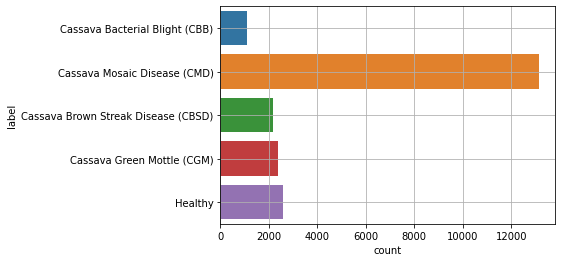

In [8]:
import numpy as np
import seaborn as sns

lb_hist= dict(zip(range(10), np.bincount(train_data['label'])))
pprint(lb_hist)

ax = sns.countplot(y=train_data['label'].map(label_mapping), orient='v')
ax.grid()

(-0.5, 799.5, 599.5, -0.5)

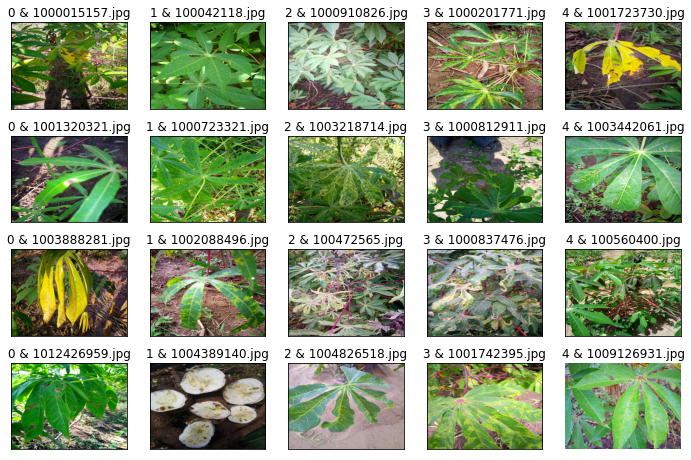

In [25]:
import matplotlib.pyplot as plt

fig, axarr = plt.subplots(nrows=4, ncols=5, figsize=(12, 8))
for lb, df_ in train_data.groupby('label'):
  img_names = list(df_['image_id'])
  for i in range(4):
    img_name = img_names[i]
    img = plt.imread(f"/content/train_images/{img_name}")
    axarr[i, lb].imshow(img)
    axarr[i, lb].set_title(f"{lb} & {img_name}")
    axarr[i, lb].set_xticks([])
    axarr[i, lb].set_yticks([])
plt.axis('off')

In [16]:
import os
import tqdm

clr_images = {0: [], 1: [], 2: []}
# just some smaller subset bc there is some random freezing without proper error/exception
for img_name in tqdm.tqdm(list(train_data['image_id'])[:1000]):
  img = plt.imread(os.path.join("/content/train_images", img_name))
  # aggregate means per channel
  for i in range(3):
    clr_images[i].append(np.mean(img[..., i]))

img_color_mean = [np.mean(clr_images[i]) for i in range(3)]
print(np.array(img_color_mean) / 255.0)

100%|██████████| 1000/1000 [00:10<00:00, 97.11it/s]

[0.43138918 0.4989732  0.31300829]


In [17]:
clr_images = {0: [], 1: [], 2: []}
# just some smaller subset bc there is some random freezing without proper error/exception
for img_name in tqdm.tqdm(list(train_data['image_id'])[:800]):
  img = plt.imread(os.path.join("/content/train_images", img_name))
  # compute STD per channel
  for i in range(3):
    std = np.sqrt(np.mean((img[..., i] - img_color_mean[i]) ** 2))
    clr_images[i].append(np.mean(std))

img_color_std = [np.mean(clr_images[i]) for i in range(3)]
print(np.array(img_color_std) / 255.0)

100%|██████████| 800/800 [00:10<00:00, 76.26it/s]

[0.23725494 0.23952537 0.2272112 ]


## DataModule

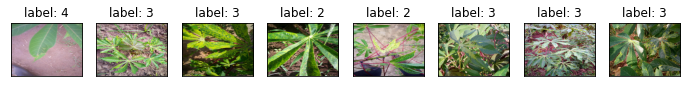

In [26]:
from clds.data import CassavaDataset

# ==============================
# ==============================

dataset = CassavaDataset()

# quick view
fig = plt.figure(figsize=(12, 4))
for i in range(8):
  img, lb = dataset[i]
  ax = fig.add_subplot(1, 8, i + 1, xticks=[], yticks=[])
  ax.imshow(img)
  ax.set_title(f"label: {lb}")

training dataset: 17117
validation dataset: 4280


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch labels: {0: 8, 1: 16, 2: 14, 3: 74, 4: 16}
image size: torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


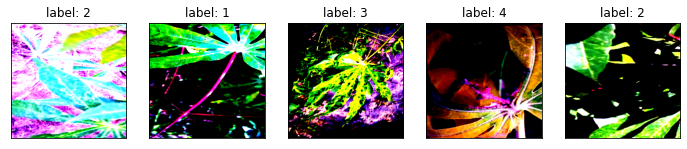

In [27]:
from clds.data import CassavaDataModule

# ==============================
# ==============================

dm = CassavaDataModule()
dm.setup()

# quick view
fig = plt.figure(figsize=(12, 4))
for imgs, lbs in dm.train_dataloader():
  lb_hist= dict(zip(range(10), np.bincount(lbs)))
  print(f'batch labels: {lb_hist}')
  print(f'image size: {imgs[0].shape}')
  for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
    ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
    ax.set_title(f"label: {lbs[i]}")
  break

## CNN Model

In [14]:
from clds.models import LitResnet, LitMobileNet, LitCassava

# ==============================
# ==============================

# see: https://pytorch.org/vision/stable/models.html
# net = LitResnet(arch='resnet18')
net = LitMobileNet(arch='mobilenet_v3_small')
print(net)
model = LitCassava(model=net)

LitMobileNet(
  (model): MobileNetV3(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (relu): ReLU(inplace=True)
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            

## Training

In [16]:
# dm = CassavaDataModule()
# dm.setup()

# !mkdir /content/weights
# weights_path = "/content/weights"
# cb_ckpt = pl.callbacks.ModelCheckpoint(
#     dirpath=weights_path,
#     save_weights_only=True,
#     monitor="valid_f1",
#     mode="max",
#     save_last=True,
# )
# ==============================

trainer = pl.Trainer(
    # fast_dev_run=True,
    gpus=1,
    # callbacks=[cb_ckpt],
    max_epochs=3,
    precision=16,
    val_check_interval=0.25,
    progress_bar_refresh_rate=1,
)

# ==============================

# trainer.tune(model, datamodule=dm)
trainer.fit(model=model, datamodule=dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.

  | Name     | Type         | Params
------------------------------------------
0 | model    | LitMobileNet | 1.5 M 
1 | accuracy | Accuracy     | 0     
2 | f1_score | F1           | 0     
------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.092     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/